In [1]:
from sim import Simulator, SimConfig
from miners.repay_proportional import RepayProportionalShortfallMinerState
from miners.burn import BurnShortfallMinerState
from miners.repay_ratchet import RepayRatchetShortfallMinerState
from network import *
from strategy import *
from consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

network = dataclasses.replace(MAINNET_FEB_2023, token_lease_fee=0.20)
epochs = 3 * YEAR + 1
stats_interval = DAY

In [2]:
def show_miner_accounting_charts(d):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(13.4, 4.8))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(d['day'], d['net_equity'], label="Net equity")
    ax1.plot(d['day'], d['balance'], label="Balance")
    ax1.plot(d['day'], d['available'], '--', label="Available")
    ax1.plot(d['day'], -d['lease'], label="Lease")
    ax1.plot(d['day'], d['pledge_locked'], '--', label="Pledge locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
    ax2.plot(d['day'], d['reward_earned'], label="Rewards")
    ax2.plot(d['day'], -d['fee_burned'], label="Shortfall fee")
    ax2.plot(d['day'], -d['lease_fee_accrued'], label="Lease fee")
    ax2.set_title("Miner cash flow")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

## Repay the shortfall

In [3]:
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
repay_shortfall_df = pd.DataFrame(data=stats)
repay_shortfall_df

,day,epoch,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,pledge_required,shortfall,shortfall_pct
0,0,0,331262237605888,1000.0000,1000.0002,1000.0000,0.0000,-0.0002,0.0000,0.0000,0.0002,2099.5805,1099.5805,52.37
1,1,2880,331262237605888,1003.0125,1000.5467,1003.0125,0.0000,2.4658,4.0169,1.0028,0.5483,2099.5805,1096.5679,52.23
2,2,5760,331262237605888,1006.0251,1001.0908,1006.0251,0.0000,4.9343,8.0338,2.0029,1.0967,2099.5805,1093.5554,52.08
3,3,8640,331262237605888,1009.0376,1001.6324,1009.0376,0.0000,7.4052,12.0508,3.0002,1.6454,2099.5805,1090.5428,51.94
4,4,11520,331262237605888,1012.0502,1002.1716,1012.0502,0.0000,9.8786,16.0677,3.9947,2.1944,2099.5805,1087.5303,51.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142080,331262237605888,3911.4953,0.0000,2099.5805,1811.9148,3911.4953,4382.4608,183.2636,287.7019,2099.5805,0.0000,0.00
1092,1092,3144960,331262237605888,3915.5122,0.0000,2099.5805,1815.9317,3915.5122,4386.4777,183.2636,287.7019,2099.5805,0.0000,0.00
1093,1093,3147840,331262237605888,3919.5291,0.0000,2099.5805,1819.9487,3919.5291,4390.4946,183.2636,287.7019,2099.5805,0.0000,0.00
1094,1094,3150720,331262237605888,3923.5460,0.0000,2099.5805,1823.9656,3923.5460,4394.5115,183.2636,287.7019,2099.5805,0.0000,0.00


<Figure size 640x480 with 0 Axes>

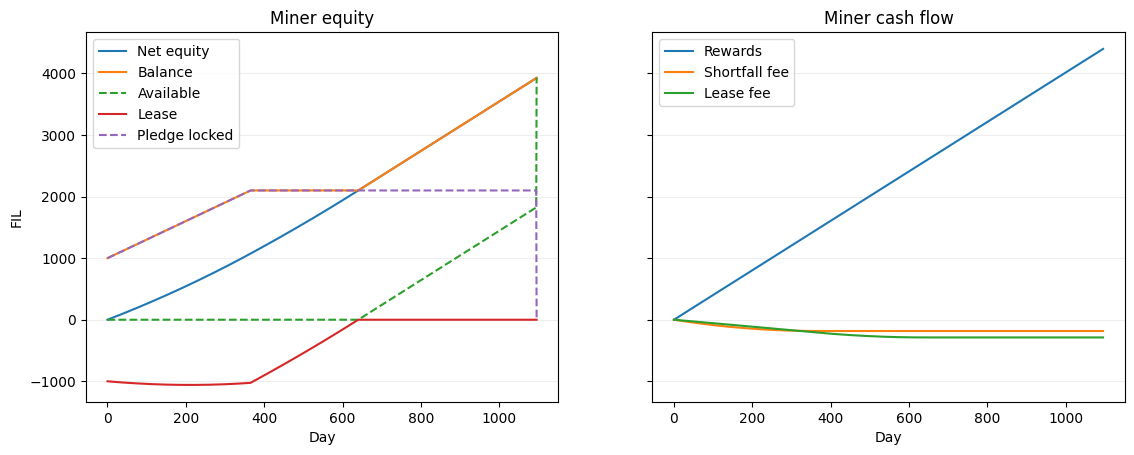

In [4]:
show_miner_accounting_charts(repay_shortfall_df)

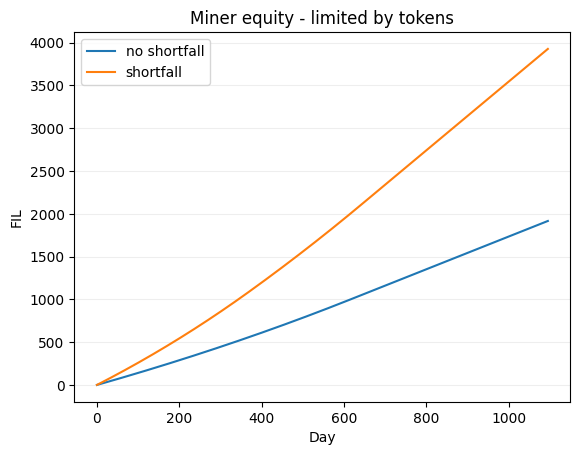

In [5]:
cfgs = {
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    )
}

statss = {label: pd.DataFrame(Simulator(cfg).run_all(epochs, stats_interval)) for (label, cfg) in cfgs.items()}

plt.grid(axis='y', color='#EEE')
for label, burn_shortfall_df in statss.items():
    plt.plot(burn_shortfall_df['day'], burn_shortfall_df['net_equity'], label=label)

plt.plot()
plt.title("Miner equity - limited by tokens")
plt.xlabel("Day")
plt.ylabel("FIL")
plt.legend()
plt.show()


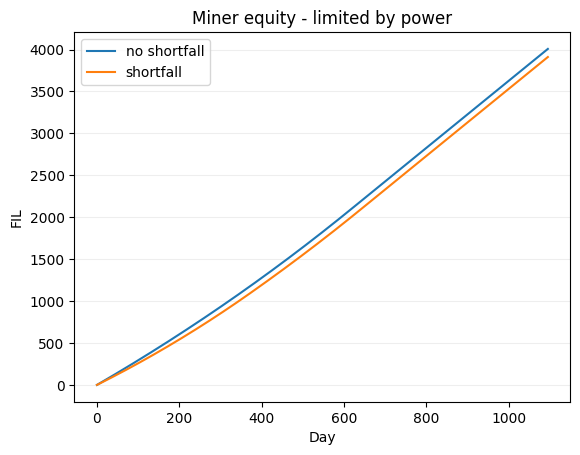

In [6]:
cfgs = {
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(300*TIBIBYTE, 3*YEAR, False),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(300*TIBIBYTE, 3*YEAR, True),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    )
}

statss = {label: pd.DataFrame(Simulator(cfg).run_all(epochs, stats_interval)) for (label, cfg) in cfgs.items()}

plt.grid(axis='y', color='#EEE')
for label, burn_shortfall_df in statss.items():
    plt.plot(burn_shortfall_df['day'], burn_shortfall_df['net_equity'], label=label)

plt.plot()
plt.title("Miner equity - limited by power")
plt.xlabel("Day")
plt.ylabel("FIL")
plt.legend()
plt.show()

## Burn the shortfall

In [7]:
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=BurnShortfallMinerState.factory(balance=0),
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
burn_shortfall_df = pd.DataFrame(data=stats)
burn_shortfall_df


,day,epoch,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,fee_pending
0,0,0,315525477433344,1000.0000,1000.0002,1000.0,0.0000,-0.0002,0.0000,0.0000,0.0002,999.8390
1,1,2880,315525477433344,1000.0000,999.5900,1000.0,0.0000,0.4100,3.8261,2.8680,0.5480,996.9709
2,2,5760,315525477433344,1000.0000,999.1768,1000.0,0.0000,0.8232,7.6522,5.7333,1.0956,994.1056
3,3,8640,315525477433344,1000.0000,998.7606,1000.0,0.0000,1.2394,11.4783,8.5959,1.6430,991.2431
4,4,11520,315525477433344,1000.0000,998.3414,1000.0,0.0000,1.6586,15.3044,11.4556,2.1902,988.3833
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142080,315525477433344,2976.3394,0.0000,1000.0,1976.3394,2976.3394,4174.2700,999.8390,198.0917,0.0000
1092,1092,3144960,315525477433344,2980.1655,0.0000,1000.0,1980.1655,2980.1655,4178.0961,999.8390,198.0917,0.0000
1093,1093,3147840,315525477433344,2983.9916,0.0000,1000.0,1983.9916,2983.9916,4181.9222,999.8390,198.0917,0.0000
1094,1094,3150720,315525477433344,2987.8177,0.0000,1000.0,1987.8177,2987.8177,4185.7483,999.8390,198.0917,0.0000


<Figure size 640x480 with 0 Axes>

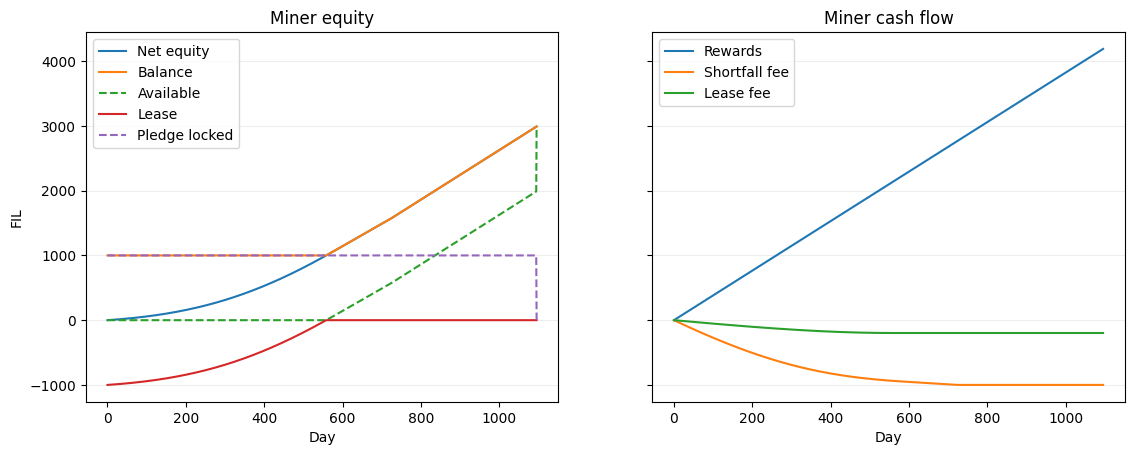

In [8]:
show_miner_accounting_charts(burn_shortfall_df)